# Customer Churn Prediction


In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from google.colab import files #used to download model from Colab
import kagglehub
import pandas as pd
from joblib import dump

#Load Data

In [2]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


In [3]:
cd /kaggle/input/telco-customer-churn

/kaggle/input/telco-customer-churn


In [4]:
ls

WA_Fn-UseC_-Telco-Customer-Churn.csv


In [5]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#Data Preprocessing

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df.describe(include="O")

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [9]:

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")


In [10]:
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [11]:
df = df.dropna()
df = df.drop(columns=["customerID"])

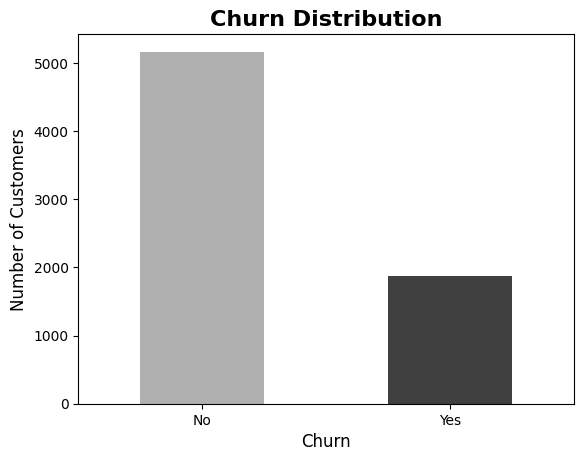

In [12]:

df['Churn'].value_counts().plot(kind='bar',color=['#B0B0B0', '#404040'])
plt.title("Churn Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Churn", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=0)
plt.show()


In [13]:
X = df.drop(columns=["Churn"])
y = df["Churn"].map({"Yes": 1, "No": 0})

In [14]:
#selecting categorical and numerical data
categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(exclude="object").columns


In [15]:
#Preprocessing of numberical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [16]:
#Train and test split of dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


#Model Training (baseline)

In [17]:
#Pipeline for preprocessing and training
model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000))
    ]
)

model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [18]:
#Running predictin with Test dataset
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8038379530916845
Confusion Matrix:
 [[917 116]
 [160 214]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



#Model Training with selected features

In [19]:

selected_features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
    "Contract",
    "InternetService",
    "OnlineSecurity",
    "TechSupport",
    "PaperlessBilling"
]

X = df[selected_features]
y = df["Churn"].map({"Yes": 1, "No": 0})

In [20]:
categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(exclude="object").columns


In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [23]:
model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000))
    ]
)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport',
       'PaperlessBilling'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [24]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7931769722814499
Confusion Matrix:
 [[909 124]
 [167 207]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.63      0.55      0.59       374

    accuracy                           0.79      1407
   macro avg       0.74      0.72      0.72      1407
weighted avg       0.79      0.79      0.79      1407



#Model save

In [25]:
#save model
dump(model, "/tmp/churn_model_pipeline.joblib")

['/tmp/churn_model_pipeline.joblib']

In [26]:
#download from Google Colab
files.download("/tmp/churn_model_pipeline.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>